In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import utils, nlp_utils
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from datetime import datetime

#nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# LDA - Wall Street Market

## Import Dataset and LDA Model Inputs

In [20]:
wallstreet = pd.read_csv('data/wallstreet_master.csv')

In [21]:
wallstreet.columns

Index(['postID', 'threadID', 'threadTitle', 'subforum', 'authorName',
       'postAuthorMembership', 'authorReputation', 'postSequence',
       'flatContent', 'contentWithHTMLTag', 'post_date_dt', 'author_join_date',
       'num_days_member_when_posted', 'wordcloud_text', 'cleaned_text',
       'lemmatized_tokens'],
      dtype='object')

In [22]:
n_topics = 25
max_doc_freq = 0.3
max_features = 10000
max_iterations = 25

lemmatized_tokens = wallstreet['lemmatized_tokens']

--- 
# Bag of Words

In [23]:
def convert_to_bow_and_fit_lda_model(docs_raw, max_feats, freq_thresh, n_topics, learning_method, max_iter, random_state=3):
    '''
    Convert text into a vector representation, i.e. Bag of Words.
    
    Args:
        docs_raw (arr) : An array comprised of numerous texts.
        max_feats (int) : Number of words to limit the bag-of-words.
        freq-thresh (float) : Words that have a document frequency greater than the selected amount will be ignored.
    Return:
        text_transformed (arr) : Vectorized texted.
    
    '''
    
    vectorizer = CountVectorizer(max_features=max_feats, max_df=freq_thresh)
    docs_vectorized = vectorizer.fit_transform(docs_raw)

    lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method=learning_method, max_iter=max_iter, random_state=random_state, n_jobs=-1)
    lda_output = lda_model.fit_transform(docs_vectorized)
    
    return lda_output, lda_model, docs_vectorized, vectorizer

In [24]:
# Must be even for visualizations.

lda_output_bow, lda_model_bow, docs_vectorized_bow, vect_bow = convert_to_bow_and_fit_lda_model(lemmatized_tokens, max_features, max_doc_freq, n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_bow.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_bow.get_feature_names())

In [25]:
nlp_utils.print_topics(lda_model_bow, vect_bow, 10)


Topic #0:
order vendor day get time support dispute buyer sent market

Topic #1:
use key using tor file click tail address user server

Topic #2:
good note review quality vendor one like product bill test

Topic #3:
per may country year drug also many information law world

Topic #4:
use mirror onionshop gold mg carding 500 store darknet biggest

Topic #5:
fullz info credit cc listing need check scan card know

Topic #6:
dont know like people would vendor forum get way think

Topic #7:
service card vendor vouch transfer usa carding nothing first fullz

Topic #8:
account bank need name drop access uk email fullz money

Topic #9:
market wsm store bump shop profile link 9a7ae0b905 street picsou

Topic #10:
get need card method money use phone service offer carding

Topic #11:
new und usd die der vendor da ich mit wir

Topic #12:
drug consider arab sand nun testicle eskimo smashedice purityring like

Topic #13:
rule get help wsm phished please allowed contact external vendor

Topic #14:
p

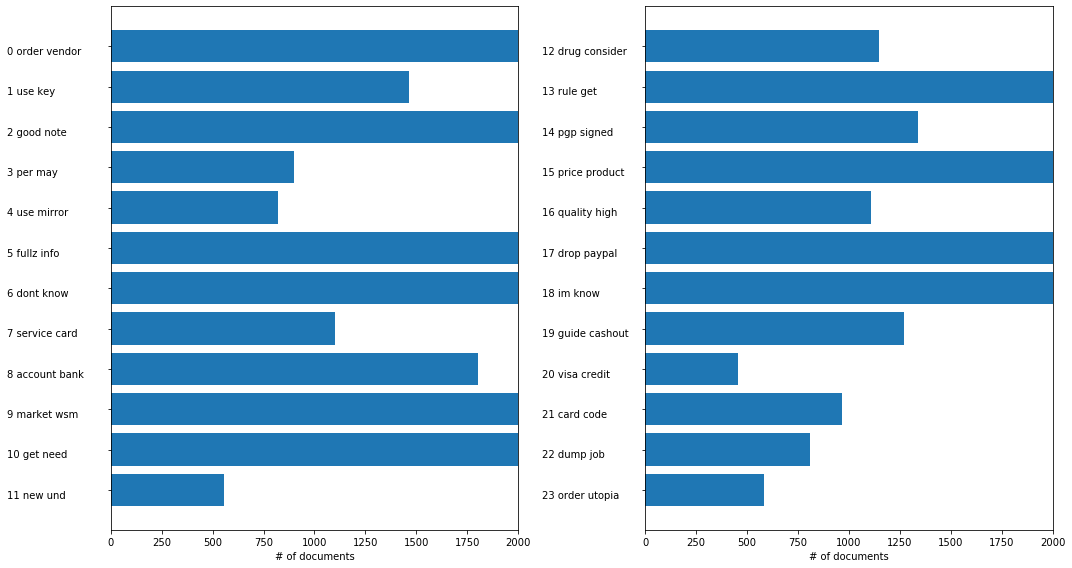

In [26]:
# Evaluate each topics (components) overall weight.
# Topics are named by the two most common words.

topics_per_plot = int(n_topics / 2)
barh_xlim = 2000
plot_pad = 100
fig_size = (15,8)
num_cols = 2

fig, ax = plt.subplots(1, 2, figsize=fig_size)

topic_names = ['{} {}'.format(i, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :2]])]

for col in range(num_cols):
    start = col * topics_per_plot
    end = (col + 1) * topics_per_plot
    plot_width = np.sum(lda_output_bow, axis=0)[start:end]
    ax[col].barh(np.arange(topics_per_plot), plot_width)
    ax[col].set_yticks(np.arange(topics_per_plot))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, barh_xlim)
    ax[col].set_xlabel('# of documents')
    y_ax = ax[col].get_yaxis()
    y_ax.set_tick_params(pad=plot_pad)

plt.tight_layout();

In [27]:
# Topic order is based on topic popularity.
# The distance b/t circles reprsents an approximation topic similarity. It's approximation b/c only a 2D map.
# When lambda = 0, the bar chart solely show topic-specific terms (jargon).
doc_term_matrix = np.matrix(lda_model_bow.components_)
pyLDAvis.sklearn.prepare(lda_model_bow, doc_term_matrix, vect_bow)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.197164  0.064405       1        1  9.885939
6      0.188188  0.035737       2        1  8.991009
0      0.113976  0.068117       3        1  8.159350
10     0.149161 -0.049888       4        1  6.750398
13    -0.094096  0.260557       5        1  5.812350
19    -0.026646 -0.012780       6        1  5.627188
2      0.061028 -0.064787       7        1  5.473404
1      0.145544  0.026910       8        1  5.186167
15    -0.113929 -0.086439       9        1  4.855493
3      0.084398 -0.105248      10        1  4.143530
17     0.097107  0.035042      11        1  4.042624
8      0.116744  0.012275      12        1  3.891864
5      0.053345  0.028105      13        1  3.705036
24     0.066301  0.093870      14        1  3.505312
23    -0.159820 -0.129300      15        1  2.959822
9     -0.241083  0.215790      16        1  2.132402
21    -0.005843 -0.088106      17        1  1.981412
4     -0.045370 -0.143641      18        1  1.957597
22     0.075354 -0.064174      19        1  1.792681
12     0.099734 -0.000250      20        1  1.788841
14    -0.142346  0.225910      21        1  1.723435
20    -0.160255 -0.212111      22        1  1.689640
7     -0.047755 -0.019137      23        1  1.537643
16    -0.217299  0.008751      24        1  1.480881
11    -0.193605 -0.099609      25        1  0.925982, topic_info=         Term          Freq         Total Category  logprob  loglift
9855      wsm  10247.000000  10247.000000  Default  30.0000  30.0000
6502      pgp   5373.000000   5373.000000  Default  29.0000  29.0000
5430   market  11507.000000  11507.000000  Default  28.0000  28.0000
7528     rule   7207.000000   7207.000000  Default  27.0000  27.0000
602   account  10487.000000  10487.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
9225   vendor    183.617380  13043.457252  Topic25  -4.3548   0.4189
4491       im     98.579655   6547.662279  Topic25  -4.9768   0.4861
51         10     83.121107   4438.721355  Topic25  -5.1474   0.7042
5854     name     77.659413   3220.355948  Topic25  -5.2153   0.9572
52        100     72.824020   2641.451304  Topic25  -5.2796   1.0910

[1830 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
6        15  0.988270       000125
8        15  0.988270       000161
9        15  0.993650       000178
15       13  0.949288  019049piece
20       22  0.982171          030
...     ...       ...          ...
9962     19  0.033225        youve
9962     20  0.251037        youve
9967      6  0.956538      youyour
9967     25  0.024527      youyour
9986     25  0.989056           zu

[6220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 7, 1, 11, 14, 20, 3, 2, 16, 4, 18, 9, 6, 25, 24, 10, 22, 5, 23, 13, 15, 21, 8, 17, 12])

### Model Performance

In [28]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', lda_model_bow.score(docs_vectorized_bow))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', lda_model_bow.perplexity(docs_vectorized_bow))

# Model parameters
print(lda_model_bow.get_params())

Log Likelihood:  -10751242.638476783
Perplexity:  1107.2991990455246
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


```
Log Likelihood:  -11984582.0120155
Perplexity:  874.359226243995
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
```

---
# TF-IDF

In [29]:
def calculate_tfidf_and_fit_lda_model(docs_raw, max_feats, freq_thresh, n_topics, learning_method, max_iter, random_state=3):
    '''
    Convert text into a vector representation, i.e. Bag of Words.
    
    Args:
        docs_raw (arr) : An array comprised of numerous texts.
        max_feats (int) : Number of words to limit the bag-of-words.
        freq-thresh (float) : Words that have a document frequency greater than the selected amount will be ignored.
    Return:
        text_transformed (arr) : Vectorized texted.
    
    '''
    
    vectorizer = TfidfVectorizer(max_features=max_feats, max_df=freq_thresh)
    docs_vectorized = vectorizer.fit_transform(docs_raw)

    lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method=learning_method, max_iter=max_iter, random_state=random_state, n_jobs=-1)
    lda_output = lda_model.fit_transform(docs_vectorized)
    
    return lda_output, lda_model, docs_vectorized, vectorizer

In [30]:
lda_output_tfidf, lda_model_tfidf, docs_vectorized_tfidf, vect_tfidf = calculate_tfidf_and_fit_lda_model(lemmatized_tokens, max_features, max_doc_freq, n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_tfidf.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_tfidf.get_feature_names())

In [31]:
nlp_utils.print_topics(lda_model_tfidf, vect_tfidf, 10)


Topic #0:
allowed read contactlink external contact please med3l1n rule jabber icq

Topic #1:
marketplace po manual digit mastercard business wall need vendor street

Topic #2:
mdma profile hash ketamine product hcl heroin ecstasy ephedrine amphetamine

Topic #3:
account bank drop paypal transfer looking card need cc uk

Topic #4:
mirror onionshop use thanks tail yes point using someone direction

Topic #5:
listing number fullz email access key credit report login score

Topic #6:
deal sample become existence unfree rebellion act absolutely world free

Topic #7:
thank scammer banned yall needed colucci steroid benzos psychadelicstimulantsbless dream

Topic #8:
external rule offsite contact trade get account allowed check link

Topic #9:
bump store 9a7ae0b905 wsm market picsou profile shop go wanted

Topic #10:
need service card get phone use method offer guide new

Topic #11:
italian coke ok rdps sim profileammaccabanane2bankdrop service selling weed cc

Topic #12:
arab sand consider 

In [32]:
doc_term_matrix = np.matrix(lda_model_tfidf.components_)
pyLDAvis.sklearn.prepare(lda_model_tfidf, doc_term_matrix, vect_tfidf)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21    -0.155596  0.022421       1        1  23.626800
10    -0.128786  0.026999       2        1   9.592250
3     -0.157993  0.053754       3        1   6.652894
13     0.100610  0.232367       4        1   5.113134
20    -0.106348  0.092514       5        1   4.844797
22    -0.031096 -0.138476       6        1   4.831383
24    -0.122315  0.052318       7        1   4.667948
15    -0.057248 -0.132660       8        1   3.868786
19    -0.013255 -0.036223       9        1   3.595152
11    -0.044481 -0.089926      10        1   3.326030
2      0.028407 -0.184583      11        1   3.230757
8      0.147530  0.055260      12        1   2.799897
17    -0.054570  0.096025      13        1   2.781502
5     -0.057005  0.025164      14        1   2.373732
14     0.185775  0.186219      15        1   2.222862
4     -0.059095  0.047792      16        1   2.152665
0      0.030748  0.156939      17        1   2.030476
12    -0.045510 -0.021659      18        1   1.950688
9      0.331249 -0.080909      19        1   1.807537
1      0.047765 -0.034308      20        1   1.540908
6      0.092046 -0.040072      21        1   1.488629
23    -0.025115 -0.066933      22        1   1.456233
7     -0.019736 -0.042930      23        1   1.414315
18     0.025645 -0.056566      24        1   1.329456
16     0.088375 -0.122528      25        1   1.301170, topic_info=         Term         Freq        Total Category  logprob  loglift
1629     bump   743.000000   743.000000  Default  30.0000  30.0000
6502      pgp   736.000000   736.000000  Default  29.0000  29.0000
9855      wsm  1373.000000  1373.000000  Default  28.0000  28.0000
8279    store   691.000000   691.000000  Default  27.0000  27.0000
7528     rule  1059.000000  1059.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1768     case    11.592236    93.758448  Topic25  -5.3934   2.2515
763     agora     8.885103    33.148137  Topic25  -5.6594   3.0253
851      also    11.867623   414.072448  Topic25  -5.3699   0.7897
2230  contact    11.319017   612.150097  Topic25  -5.4173   0.3514
3968       go    10.701703   342.322419  Topic25  -5.4734   0.8766

[1607 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9        12  0.873559   000178
16       22  0.911895      01g
23       21  0.866713      03g
30        8  0.202479     05mg
30       23  0.708676     05mg
...     ...       ...      ...
9967      9  0.824079  youyour
9972      4  0.840198      yup
9975      7  0.976529    zelle
9981     21  0.635952  zipcode
9986     10  0.938122       zu

[6687 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 11, 4, 14, 21, 23, 25, 16, 20, 12, 3, 9, 18, 6, 15, 5, 1, 13, 10, 2, 7, 24, 8, 19, 17])

In [33]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', round(lda_model_tfidf.score(docs_vectorized_tfidf), 2))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', round(lda_model_tfidf.perplexity(docs_vectorized_tfidf), 2))

# Model parameters
print(lda_model_tfidf.get_params())

Log Likelihood:  -1678949.09
Perplexity:  8337.82
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
